In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions_NLM import estimate_nested_logit, simulate_choice
from functions_NLM import multivariate_lognormal_pdf, largest_cluster_size

In [2]:
# Define log-likelihood function for telephone data
# beta will be beta = ["ASC_1", "ASC_3", "ASC_4", "ASC_5", "BETA_COST"]

# DEFINE MODEL STRUCTURE AND LIKELIHOOD FUNCTION
def log_likelihood_telephone_LM(beta, data):
    # Define utility functions
    data['U_1'] = beta[0] + beta[4] * data['logcost1'] 
    data['U_2'] = beta[4] * data['logcost2'] 
    data['U_3'] = beta[1] + beta[4] * data['logcost3']
    data['U_4'] = beta[2] + beta[4] * data['logcost4']
    data['U_5'] = beta[3] + beta[4] * data['logcost5']

    sum_total = np.exp(data['U_1']) * data['avail1'] + np.exp(data['U_2']) * data['avail2'] + \
                np.exp(data['U_3']) * data['avail3'] + np.exp(data['U_4']) * data['avail4'] + \
                np.exp(data['U_5']) * data['avail5']
    
    # Full probabilities
    data['P_1'] = np.exp(data['U_1']) * data['avail1'] / sum_total
    data['P_2'] = np.exp(data['U_2']) * data['avail2'] / sum_total
    data['P_3'] = np.exp(data['U_3']) * data['avail3'] / sum_total
    data['P_4'] = np.exp(data['U_4']) * data['avail4'] / sum_total
    data['P_5'] = np.exp(data['U_5']) * data['avail5'] / sum_total
    
    # Calculate probability for chosen alternative for each row
    data['P'] = (data['choice'] == 1) * data['P_1'] + \
                (data['choice'] == 2) * data['P_2'] + \
                (data['choice'] == 3) * data['P_3'] + \
                (data['choice'] == 4) * data['P_4'] + \
                (data['choice'] == 5) * data['P_5']
    
    # Replace zero probabilities with small value to avoid LL = -inf
    epsilon = 1e-20
    data.loc[data['P'] == 0, 'P'] = epsilon
    
    # Calculate log-likelihood 
    LL = data['P'].apply(np.log).sum()
    
    return -LL  # We minimize negative log-likelihood

In [3]:
# Load data
data = pd.read_csv('../data/telephone.dat', sep='\t')

data['logcost1'] = np.log(data['cost1'])
data['logcost2'] = np.log(data['cost2'])
data['logcost3'] = np.log(data['cost3'])
data['logcost4'] = np.log(data['cost4'])
data['logcost5'] = np.log(data['cost5'])

# Define model parameters
beta = np.array([0, 0, 0, 0, 0])

beta_names = ["ASC_1", "ASC_3", "ASC_4", "ASC_5", "BETA_COST"]


In [4]:
# Estimate parameters
result, se, t_stat, p_value, aic, bic  = estimate_nested_logit(data, beta, beta_names, log_likelihood_telephone_LM)

Optimization Results:
   Parameter  Estimate  Robust Asymptotic SE  t-statistic       p-value
0      ASC_1 -0.721243              0.153463    -4.699777  3.514203e-06
1      ASC_3  1.201266              0.154843     7.757947  6.372680e-14
2      ASC_4  0.999199              0.702369     1.422612  1.555754e-01
3      ASC_5  1.736400              0.275862     6.294454  7.631404e-10
4  BETA_COST -2.026204              0.213538    -9.488723  0.000000e+00
AIC: 965.1137706159915
BIC: 985.4789932864935
Log-likelihood: -477.55688530799574


In [5]:
from functions_geom_DIB import geom_DIB_on_alternatives

<h2> We need to change the way we handle missing values for alternative 4 and 5. We take the mean vector by removing the missing values. </h2>

In [6]:
df_logcost = data[['logcost1', 'logcost2', 'logcost3', 'logcost4', 'logcost5']]

# Compute the mean vector and covariance matrix
log_df_logcost = np.log(df_logcost)
mean_vector = log_df_logcost.mean()

#covariance_matrix = log_df_logcost.cov()

# # Compute the mean for alternative 4 and 5 by removing missing values
true_alt_4 = log_df_logcost['logcost4'] * data['avail4']
true_alt_5 = log_df_logcost['logcost5'] * data['avail5']
true_alt_4 = true_alt_4[true_alt_4 != 0]
true_alt_5 = true_alt_5[true_alt_5 != 0]
mean_vector[3] = true_alt_4.mean()
mean_vector[4] = true_alt_5.mean()

# # Compute diagonal covariance matrix 
var1 = log_df_logcost['logcost1'].var()
var2 = log_df_logcost['logcost2'].var()
var3 = log_df_logcost['logcost3'].var()
var4 = true_alt_4.var()
var5 = true_alt_5.var()

cov12 = log_df_logcost['logcost1'].cov(log_df_logcost['logcost2'])
cov13 = log_df_logcost['logcost1'].cov(log_df_logcost['logcost3'])
cov14 = log_df_logcost['logcost1'].cov(true_alt_4)
cov15 = log_df_logcost['logcost1'].cov(true_alt_5)
cov23 = log_df_logcost['logcost2'].cov(log_df_logcost['logcost3'])
cov24 = log_df_logcost['logcost2'].cov(true_alt_4)
cov25 = log_df_logcost['logcost2'].cov(true_alt_5)
cov34 = log_df_logcost['logcost3'].cov(true_alt_4)
cov35 = log_df_logcost['logcost3'].cov(true_alt_5)
cov45 = true_alt_4.cov(true_alt_5)


covariance_matrix = np.array([[var1, cov12, cov13, cov14, cov15],
                              [cov12, var2, cov23, cov24, cov25],
                              [cov13, cov23, var3, cov34, cov35],
                              [cov14, cov24, cov34, var4, cov45],
                              [cov15, cov25, cov35, cov45, var5]])

# Compute the diagonal covariance matrix
covariance_matrix = np.diag([var1, var2, var3, var4, var5])

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3682/3736764326.py:14: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  mean_vector[3] = true_alt_4.mean()
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3682/3736764326.py:15: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  mean_vector[4] = true_alt_5.mean()


In [7]:
covariance_matrix

array([[0.09575287, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.05388416, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.02392098, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.10919936, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.00178899]])

In [8]:
np.linalg.det(covariance_matrix)

2.4111199883431552e-08

---
---
---
---
---

<h2> We simulate data </h2>

In [9]:
my_mean_vector = np.array([1,1,1,1,1])
my_covariance_matrix = np.diag([1.0, 1.0, 1.0, 1.0, 1.0])
# my_covariance_matrix[1,0] = 0.9
# my_covariance_matrix[0,1] = 0.9

In [10]:
np.random.seed(123)
simulated_data_normal = np.random.multivariate_normal(my_mean_vector, my_covariance_matrix, size=1000)

simulated_data_lognormal = np.exp(simulated_data_normal)

In [11]:
# make a dataframe from the simulated data
simulated_data_lognormal_df = pd.DataFrame(simulated_data_lognormal,
                                            columns=['logcost1', 'logcost2', 'logcost3',
                                                      'logcost4', 'logcost5'])


In [12]:
simulated_data_lognormal_df

,logcost1,logcost2,logcost3,logcost4,logcost5
0,0.917933,7.369467,3.607368,0.602725,1.524093
1,14.174386,0.240105,1.770191,9.640146,1.142547
2,1.378663,2.472651,12.078048,1.434904,1.743715
3,1.760590,24.678442,24.210492,7.419071,3.999568
4,5.682371,12.070109,1.066270,8.809486,0.775784
...,...,...,...,...,...
995,6.314367,2.320802,6.651240,18.405183,1.317929
996,5.030033,6.516639,9.491782,3.109492,1.109525
997,0.586571,5.685691,7.539937,7.324248,5.271357
998,0.960159,7.055790,0.402450,5.920659,0.943707


In [13]:
def multivariate_lognormal_integral(interval_bounds, mean, covariance_matrix, num_samples=50000):
    """
    Calculate the integral of the multivariate lognormal PDF over a chosen interval in five dimensions using Monte Carlo integration.

    Parameters:
        interval_bounds (list of tuples): List of tuples specifying the lower and upper bounds of the interval for each dimension.
        mean (array-like): Mean vector of the multivariate lognormal distribution.
        covariance_matrix (2D array-like): Covariance matrix of the multivariate lognormal distribution.
        num_samples (int): Number of samples to use in Monte Carlo integration. Default is 50000.

    Returns:
        float: Estimated value of the integral.
    """
    # Generate random samples within the specified interval
    samples = []
    for bounds in interval_bounds:
        lower_bound, upper_bound = bounds
        samples.append(np.random.uniform(lower_bound, upper_bound, num_samples))
    samples = np.array(samples).T
    
    # transform samples into a dataframe of 5 columns
    samples = pd.DataFrame(samples, columns=['logcost1', 'logcost2', 'logcost3', 'logcost4', 'logcost5'])

    # Calculate the PDF values for the each sample point
    pdf_values = samples.apply(lambda row: multivariate_lognormal_pdf(row.values,
                                                                       mean, covariance_matrix), axis=1)

    # Estimate the integral using Monte Carlo integration
    integral_estimate = np.mean(pdf_values)
    print(integral_estimate)
    interval_volume = np.prod([upper_bound - lower_bound for lower_bound, upper_bound in interval_bounds])
    integral_estimate *= interval_volume

    return integral_estimate

In [14]:
# Define intervals for each dimension
num_intervals = 3 # Number of intervals for each dimension
intervals = []
for i in range(len(mean_vector)):
    min_val = np.min(simulated_data_lognormal[:, i])
    min_val_integer = np.floor(min_val)
    max_val = np.max(simulated_data_lognormal[:, i])
    max_val_integer = np.ceil(max_val)
    interval_width = (max_val_integer - min_val_integer) / num_intervals
    interval_edges = np.linspace(min_val_integer, max_val_integer, num_intervals + 1)
    intervals.append(interval_edges)


In [15]:
intervals

[array([ 0.        , 19.33333333, 38.66666667, 58.        ]),
 array([ 0.        , 32.33333333, 64.66666667, 97.        ]),
 array([ 0., 16., 32., 48.]),
 array([ 0., 15., 30., 45.]),
 array([ 0.        , 17.66666667, 35.33333333, 53.        ])]

In [16]:
# Initialize dictionary to store results
integral_results = {}

# Calculate the mean and covariance matrix of the simulated data
log_sim_data = np.log(simulated_data_lognormal_df)

# mean_simulated_data = log_sim_data.mean()
# cov_simulated_data = log_sim_data.cov()
# cov_simulated_data *= 2
#covariance_matrix = np.diag([var1, var2, var3, var4, var5])
mean_vector = my_mean_vector.copy()
covariance_matrix = np.diag([1.0, 1.0, 1.0, 1.0, 1.0])

# artificially increase variance of logcost5
#cov_simulated_data.loc['logcost5', 'logcost5'] *= 20
#covariance_matrix[4,4] = 10 * covariance_matrix[4,4]

# Add covariances
# covariance_matrix[0,1] = 0.9
# covariance_matrix[1,0] = 0.9
# covariance_matrix[0,2] = 0.03
# covariance_matrix[2,0] = 0.03
# covariance_matrix[1,2] = 0.025
# covariance_matrix[2,1] = 0.025

# Iterate over the first n-1 values in each dimension
for i in range(len(intervals[0]) - 1):
    for j in range(len(intervals[1]) - 1):
        for k in range(len(intervals[2]) - 1):
            for l in range(len(intervals[3]) - 1):
                for m in range(len(intervals[4]) - 1):
                    # Calculate the difference between consecutive values in each dimension
                    diff_1 = intervals[0][i + 1] - intervals[0][i]
                    diff_2 = intervals[1][j + 1] - intervals[1][j]
                    diff_3 = intervals[2][k + 1] - intervals[2][k]
                    diff_4 = intervals[3][l + 1] - intervals[3][l]
                    diff_5 = intervals[4][m + 1] - intervals[4][m]
                    
                    # Define the interval bounds using the differences calculated
                    interval_bounds = [(intervals[0][i], intervals[0][i] + diff_1),
                                       (intervals[1][j], intervals[1][j] + diff_2),
                                       (intervals[2][k], intervals[2][k] + diff_3),
                                       (intervals[3][l], intervals[3][l] + diff_4),
                                       (intervals[4][m], intervals[4][m] + diff_5)]
                    
                    # Calculate the integral for the current interval bounds
                    integral_value = multivariate_lognormal_integral(interval_bounds,
                                                                      mean_vector, covariance_matrix,
                                                                      num_samples=20000)
                    # Store the integral value in the results dictionary
                    integral_results[tuple(interval_bounds)] = integral_value

# Print the integral value for each interval combination
for interval_bounds, integral_value in integral_results.items():
    print("Integral over interval bounds {}: {}".format(interval_bounds, integral_value))


7.128801603174002e-07
7.786157214121407e-72
1.8053216600720863e-269
6.5548474332388255e-59
4.562134587289257e-121
8.53256e-319
1.4720740396340938e-194
1.702201419251455e-266
0.0
1.8586797709857725e-61
2.2232939019368365e-133
0.0
7.597468865250903e-117
2.0709677569904428e-177
0.0
2.16187259974666e-259
5.9324873e-317
0.0
3.0899379339518503e-225
5.0803873997666525e-291
0.0
4.959813835011065e-266
0.0
0.0
0.0
0.0
0.0
1.2538650702250552e-230
1.495312010614066e-308
0.0
5.987543183322494e-275
0.0
0.0
0.0
0.0
0.0
1.6702591250218497e-276
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.065715431891731e-83
4.647544551488565e-150
0.0
2.6009512643430102e-136
6.841769656609415e-206
0.0
1.2167715711074866e-281
0.0
0.0
1.0020833174303167e-135
4.884823836297762e-210
0.0
1.1907473028410517e-205
1.686193051604343e-269
0.0
2e-323
0.0
0.0
1.4630053167720505e-297
0.0
0.0
0.0
0.0
0

In [17]:
# Initialize an empty list to store the probabilities
probabilities = []

# Iterate over each datapoint
for datapoint in simulated_data_lognormal:
    # Initialize a variable to store the probability of the interval containing the datapoint
    probability = 0.0
    
    # Iterate over each interval in the integral results
    for interval_bounds, integral_value in integral_results.items():
        # Check if the datapoint falls within the interval
        if all(lower_bound <= value < upper_bound for (lower_bound, upper_bound), value in zip(interval_bounds, datapoint)):
            # If the datapoint is within the interval, assign the probability of that interval
            probability = integral_value
            break  # Exit the loop once the interval is found
    
    # Append the probability to the list of probabilities
    probabilities.append(probability)

# Add the list of probabilities as a new column to your DataFrame
simulated_data_lognormal_df['Probability'] = probabilities

---
---
---

<h2> Simulate utility using Gumbel distribution, then apply logit formula for the probabilities p(y|x) and then take the choice by the Evangelos procedure </h2>

<h3> We take the same theta as the ones that we found with the real data and we simulate choices by taking error terms as EV(0,1) </h3>

In [18]:
theta_calculated = result.x
#theta_calculated[4] = -2.5

# function to simulate a choice for a given individual 
def simulated_choice_from_logcosts(logcosts): 
    U_1 = theta_calculated[0] + theta_calculated[4] * logcosts.iloc[0] + np.random.gumbel()
    U_2 = theta_calculated[4] * logcosts.iloc[1] + np.random.gumbel()
    U_3 = theta_calculated[1] + theta_calculated[4] * logcosts.iloc[2] + np.random.gumbel()
    U_4 = theta_calculated[2] + theta_calculated[4] * logcosts.iloc[3] + np.random.gumbel()
    U_5 = theta_calculated[3] + theta_calculated[4] * logcosts.iloc[4] + np.random.gumbel()

    sum_total = np.exp(U_1) + np.exp(U_2) + np.exp(U_3) + np.exp(U_4) + np.exp(U_5)

    P_1 = np.exp(U_1) / sum_total
    P_2 = np.exp(U_2) / sum_total
    P_3 = np.exp(U_3) / sum_total
    P_4 = np.exp(U_4) / sum_total
    P_5 = np.exp(U_5) / sum_total

    probabilities_df = pd.DataFrame({'P_1': [P_1], 'P_2': [P_2], 'P_3': [P_3], 'P_4': [P_4], 'P_5': [P_5]})

    choice = simulate_choice(probabilities_df.iloc[0])

    return P_1, P_2, P_3, P_4, P_5, choice

In [19]:
# simulate a choice for each individual in the simulated data and keep probability of each choice in the dataset
simulated_data_lognormal_df[['P_1', 'P_2', 'P_3', 'P_4', 'P_5', 'simulated_choice']] = simulated_data_lognormal_df.apply(simulated_choice_from_logcosts, axis=1, result_type='expand')

In [20]:
simulated_data_lognormal_df

,logcost1,logcost2,logcost3,logcost4,logcost5,Probability,P_1,P_2,P_3,P_4,P_5,simulated_choice
0,0.917933,7.369467,3.607368,0.602725,1.524093,1.889468e+00,2.498145e-01,3.095675e-07,1.237579e-03,6.681489e-01,0.080799,4.0
1,14.174386,0.240105,1.770191,9.640146,1.142547,1.889468e+00,2.713322e-14,9.105232e-01,1.587348e-02,3.752080e-08,0.073603,2.0
2,1.378663,2.472651,12.078048,1.434904,1.743715,1.889468e+00,1.175304e-01,1.476195e-02,2.250336e-10,7.824151e-01,0.085293,4.0
3,1.760590,24.678442,24.210492,7.419071,3.999568,4.926377e-55,8.843462e-01,1.023113e-20,2.119590e-19,2.137222e-05,0.115632,1.0
4,5.682371,12.070109,1.066270,8.809486,0.775784,1.889468e+00,1.828584e-07,4.500180e-12,1.274243e-01,1.007590e-08,0.872576,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,6.314367,2.320802,6.651240,18.405183,1.317929,1.737343e-52,9.812620e-05,2.579235e-02,2.063377e-04,1.667066e-14,0.973903,5.0
996,5.030033,6.516639,9.491782,3.109492,1.109525,1.889468e+00,4.846770e-06,8.580294e-07,3.608818e-09,4.392484e-03,0.995602,5.0
997,0.586571,5.685691,7.539937,7.324248,5.271357,1.889468e+00,9.995272e-01,2.081652e-04,3.603969e-06,6.522734e-06,0.000254,1.0
998,0.960159,7.055790,0.402450,5.920659,0.943707,1.889468e+00,1.055043e-02,1.233435e-07,7.854631e-01,1.997893e-06,0.203984,3.0


---
---
---
---
---

In [21]:
# Computation of p(x,y)
p_x = simulated_data_lognormal_df['Probability'].values
# Replace zero probabilities with small value
epsilon = 1e-300
p_x[p_x == 0] += epsilon

p_y_given_x = simulated_data_lognormal_df[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].values
p_xy = p_x[:, np.newaxis] * p_y_given_x

# Normalize p_xy 
p_xy /= p_xy.sum()

/Users/alex/Documents/GitHub/Semester_project_information_cluser/notebook-telephone/functions_IB.py:26: RuntimeWarning: invalid value encountered in multiply
  kl = np.sum(p * np.log(p / q))


Iteration: 1 out of 5000
Objective function value: 1.60914443214705
H(T) =  1.60914443214705
I(T;Y) =  0.003674735368059956
Iteration: 2 out of 5000
Objective function value: 0.8861070576107382
H(T) =  0.8861070576107382
I(T;Y) =  0.0007467685561115545
Iteration: 3 out of 5000
Objective function value: 0.6601485745864698
H(T) =  0.6601485745864698
I(T;Y) =  0.000494553597454761
Iteration: 4 out of 5000
Objective function value: 0.5306767563072672
H(T) =  0.5306767563072672
I(T;Y) =  0.0003695533761347569
Iteration: 5 out of 5000
Objective function value: 0.44635512960950413
H(T) =  0.44635512960950413
I(T;Y) =  0.00029496055348809946
Iteration: 6 out of 5000
Objective function value: 0.3867544493551085
H(T) =  0.3867544493551085
I(T;Y) =  0.00024541234671149326
Iteration: 7 out of 5000
Objective function value: 0.3422097518461232
H(T) =  0.3422097518461232
I(T;Y) =  0.00021011218155919664
Iteration: 8 out of 5000
Objective function value: 0.3075474690223561
H(T) =  0.3075474690223561
I

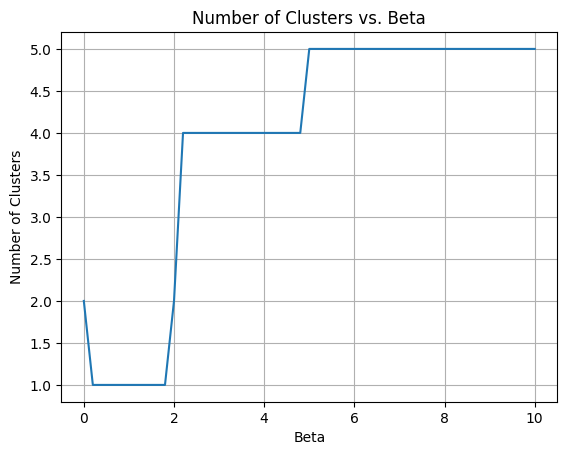

In [22]:
betas = np.linspace(0, 10, 51)
# Initialize an empty list to store the number of clusters
num_clusters_list = []
largest_cluster_sizes = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB_on_alternatives(p_xy, max_iter=5000, beta=beta, threshold=1e-4)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

        # Calculate the size of the largest cluster
    largest_size = largest_cluster_size(q_t_given_x)
    # Append the size of the largest cluster to the list
    largest_cluster_sizes.append(largest_size)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

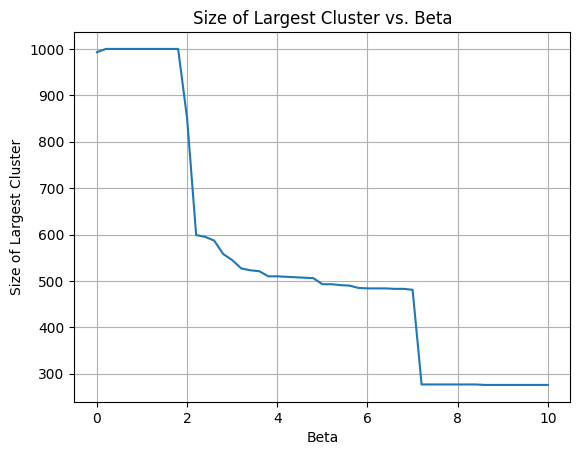

In [23]:
# Plot the number of elements in the largest cluster against beta values
plt.plot(betas, largest_cluster_sizes)
plt.xlabel('Beta')
plt.ylabel('Size of Largest Cluster')
plt.title('Size of Largest Cluster vs. Beta')
plt.grid(True)
plt.show()

In [24]:
q_t_given_x, q_t, q_y_given_t = geom_DIB_on_alternatives(p_xy, beta=4, max_iter=50000, threshold=1e-5)

Iteration: 1 out of 50000
Objective function value: 1.5944454906748102
H(T) =  1.60914443214705
I(T;Y) =  0.003674735368059956
Iteration: 2 out of 50000
Objective function value: -0.4452154543283684
H(T) =  1.396634172282892
I(T;Y) =  0.4604624066528151
Iteration: 3 out of 50000
Objective function value: -0.8977620244484901
H(T) =  1.3889040543130924
I(T;Y) =  0.5716665196903956
Iteration: 4 out of 50000
Objective function value: -0.9488849052628243
H(T) =  1.317798673747074
I(T;Y) =  0.5666708947524746
Iteration: 5 out of 50000
Objective function value: -0.9312096555459255
H(T) =  1.2261929902126654
I(T;Y) =  0.5393506614396477
Iteration: 6 out of 50000
Objective function value: -0.8289569267307921
H(T) =  1.4169213217784933
I(T;Y) =  0.5614695621273214
Iteration: 7 out of 50000
Objective function value: -0.841660247812319
H(T) =  1.3950351612766865
I(T;Y) =  0.5591738522722514
Iteration: 8 out of 50000
Objective function value: -0.850845511347939
H(T) =  1.3766760630068873
I(T;Y) =  

In [25]:
# Calculate the number of clusters
column_sum = np.sum(q_t_given_x, axis=0)
num_clusters = np.count_nonzero(column_sum)
print('Number of clusters :', num_clusters)

# Count the number of observations in each cluster
simulated_data_lognormal_df['cluster'] = np.argmax(q_t_given_x, axis=1)
print('\n', simulated_data_lognormal_df['cluster'].value_counts())

simulated_data_lognormal_df['max_proba'] = simulated_data_lognormal_df[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].idxmax(axis=1).str[-1].astype(int)
cluster_counts2 = simulated_data_lognormal_df.groupby(['cluster', 'max_proba']).size().unstack(fill_value=0)
print('\n', cluster_counts2)

cluster_counts3 = simulated_data_lognormal_df.groupby(['cluster', 'simulated_choice']).size().unstack(fill_value=0)
print('\n', cluster_counts3)

Number of clusters : 4

 cluster
0    510
4    237
2    150
1    103
Name: count, dtype: int64

 max_proba   1    2    3    4    5
cluster                          
0           0    2  233    4  271
1          97    0    4    0    2
2           0  138    3    1    8
4           0    0    3  219   15

 simulated_choice  1.0  2.0  3.0  4.0  5.0
cluster                                  
0                  14   12  200   22  262
1                  70   10   10    5    8
2                   5  111    9    7   18
4                  14    9   18  168   28


---
---
---
---
---

<h2> Nested logit model </h2>

In [26]:
# Define log-likelihood function for telephone data
# beta will be beta = ["ASC_1", "ASC_3", "ASC_4", "ASC_5", "BETA_COST", "lambda_measured", "lambda_flat"]

def log_likelihood_telephone_NLM(beta, data):
    # Define utility functions
    data['U_1'] = beta[0] + beta[4] * data['logcost1'] 
    data['U_2'] = beta[4] * data['logcost2'] 
    data['U_3'] = beta[1] + beta[4] * data['logcost3']
    data['U_4'] = beta[2] + beta[4] * data['logcost4']
    data['U_5'] = beta[3] + beta[4] * data['logcost5']
    
    # Calculate logsum for nests with > 1 alt
    data['logsum_measured'] = np.log(data['avail1'] * np.exp(data['U_1'] / beta[5])
                                        + data['avail2'] * np.exp(data['U_2'] / beta[5])
                                        + (1 - data['avail1']) * (1 - data['avail2']))
    data['logsum_flat'] = np.log(data['avail3'] * np.exp(data['U_3'] / beta[6])
                                    + data['avail4'] * np.exp(data['U_4'] / beta[6])
                                    + data['avail5'] * np.exp(data['U_5'] / beta[6])
                                    + (1 - data['avail3']) * (1 - data['avail4']) * (1 - data['avail5']))
    
    # Nest probabilities
    data['P_nest_measured'] = np.exp(beta[5] * data['logsum_measured']) / \
                                 (np.exp(beta[5] * data['logsum_measured']) 
                                  + np.exp(beta[6] * data['logsum_flat']))
    data['P_nest_flat'] = 1 - data['P_nest_measured']
    
    # Within nest probabilities for nests with > 1 alt
    data['P_1_in_measured'] = data['avail1'] * np.exp(data['U_1'] / beta[5]) / \
                                (data['avail1'] * np.exp(data['U_1'] / beta[5]) 
                                 + data['avail2'] * np.exp(data['U_2'] / beta[5]))
    data['P_2_in_measured'] = 1 - data['P_1_in_measured']

    data['P_3_in_flat'] = data['avail3'] * np.exp(data['U_3'] / beta[6]) / \
                            (data['avail3'] * np.exp(data['U_3'] / beta[6])
                                + data['avail4'] * np.exp(data['U_4'] / beta[6])
                                + data['avail5'] * np.exp(data['U_5'] / beta[6]))
    data['P_4_in_flat'] = data['avail4'] * np.exp(data['U_4'] / beta[6]) / \
                            (data['avail3'] * np.exp(data['U_3'] / beta[6])
                                + data['avail4'] * np.exp(data['U_4'] / beta[6])
                                + data['avail5'] * np.exp(data['U_5'] / beta[6]))
    data['P_5_in_flat'] = 1 - data['P_3_in_flat'] - data['P_4_in_flat']
    
    # Full probabilities
    data['P_1'] = data['P_nest_measured'] * data['P_1_in_measured']
    data['P_2'] = data['P_nest_measured'] * data['P_2_in_measured']
    data['P_3'] = data['P_nest_flat'] * data['P_3_in_flat']
    data['P_4'] = data['P_nest_flat'] * data['P_4_in_flat']
    data['P_5'] = data['P_nest_flat'] * data['P_5_in_flat']
    
    # Calculate probability for chosen alternative for each row
    data['P'] = (data['choice'] == 1) * data['P_1'] + \
                (data['choice'] == 2) * data['P_2'] + \
                (data['choice'] == 3) * data['P_3'] + \
                (data['choice'] == 4) * data['P_4'] + \
                (data['choice'] == 5) * data['P_5']
    
    # Replace zero probabilities with small value to avoid LL = -inf
    epsilon = 1e-20
    data.loc[data['P'] == 0, 'P'] = epsilon
    
    # Calculate log-likelihood 
    LL = data['P'].apply(np.log).sum()
    
    return -LL  # We minimize negative log-likelihood

In [28]:
# Load data
data2 = pd.read_csv('../data/telephone.dat', sep='\t')

data2['logcost1'] = np.log(data2['cost1'])
data2['logcost2'] = np.log(data2['cost2'])
data2['logcost3'] = np.log(data2['cost3'])
data2['logcost4'] = np.log(data2['cost4'])
data2['logcost5'] = np.log(data2['cost5'])

# Define model parameters
beta2 = np.array([0, 0, 0, 0, 0, 1, 1])

beta_names2 = ["ASC_1", "ASC_3", "ASC_4", "ASC_5", "BETA_COST", "lambda_measured", "lambda_flat"]


In [29]:
# Estimate parameters
result2, se2, t_stat2, p_value2, aic2, bic2  = estimate_nested_logit(data2, beta2, beta_names2, log_likelihood_telephone_NLM)

Optimization Results:
         Parameter  Estimate  Robust Asymptotic SE  t-statistic       p-value
0            ASC_1 -0.378246              0.125454    -3.015006  2.723024e-03
1            ASC_3  0.893446              0.171565     5.207627  2.980374e-07
2            ASC_4  0.847293              0.393757     2.151815  3.197195e-02
3            ASC_5  1.405502              0.259374     5.418828  1.004633e-07
4        BETA_COST -1.490024              0.252883    -5.892149  7.739943e-09
5  lambda_measured  0.484798              0.139705     3.470160  5.730726e-04
6      lambda_flat  0.436216              0.121307     3.595981  3.609402e-04
AIC: 960.4386663193137
BIC: 988.9499780580165
Log-likelihood: -473.21933315965686


In [30]:
theta_calculated = result2.x
#theta_calculated[4] = -2.5

# function to simulate a choice for a given individual 
def simulated_choice_from_logcosts_NLM(logcosts): 
    U_1 = theta_calculated[0] + theta_calculated[4] * logcosts.iloc[0] + np.random.gumbel()
    U_2 = theta_calculated[4] * logcosts.iloc[1] + np.random.gumbel()
    U_3 = theta_calculated[1] + theta_calculated[4] * logcosts.iloc[2] + np.random.gumbel()
    U_4 = theta_calculated[2] + theta_calculated[4] * logcosts.iloc[3] + np.random.gumbel()
    U_5 = theta_calculated[3] + theta_calculated[4] * logcosts.iloc[4] + np.random.gumbel()

    log_sum_measured = np.log(np.exp(U_1 / theta_calculated[5]) + np.exp(U_2 / theta_calculated[5]))
    log_sum_flat = np.log(np.exp(U_3 / theta_calculated[6]) + np.exp(U_4 / theta_calculated[6]) + np.exp(U_5 / theta_calculated[6]))

    P_nest_measured = np.exp(theta_calculated[5] * log_sum_measured) / \
                        (np.exp(theta_calculated[5] * log_sum_measured) + np.exp(theta_calculated[6] * log_sum_flat))
    P_nest_flat = 1 - P_nest_measured

    P_1_in_measured = np.exp(U_1 / theta_calculated[5]) / \
                        (np.exp(U_1 / theta_calculated[5]) + np.exp(U_2 / theta_calculated[5])) 
    P_2_in_measured = 1 - P_1_in_measured

    P_3_in_flat = np.exp(U_3 / theta_calculated[6]) / \
                    (np.exp(U_3 / theta_calculated[6]) + np.exp(U_4 / theta_calculated[6]) + np.exp(U_5 / theta_calculated[6]))
    P_4_in_flat = np.exp(U_4 / theta_calculated[6]) / \
                    (np.exp(U_3 / theta_calculated[6]) + np.exp(U_4 / theta_calculated[6]) + np.exp(U_5 / theta_calculated[6])) 
    P_5_in_flat = 1 - P_3_in_flat - P_4_in_flat
    
    P_1 = P_nest_measured * P_1_in_measured
    P_2 = P_nest_measured * P_2_in_measured
    P_3 = P_nest_flat * P_3_in_flat
    P_4 = P_nest_flat * P_4_in_flat
    P_5 = P_nest_flat * P_5_in_flat

    probabilities_df = pd.DataFrame({'P_1': [P_1], 'P_2': [P_2], 'P_3': [P_3], 'P_4': [P_4], 'P_5': [P_5]})

    choice = simulate_choice(probabilities_df.iloc[0])

    return P_1, P_2, P_3, P_4, P_5, choice

In [31]:
# simulate a choice for each individual in the simulated data and keep probability of each choice in the dataset
simulated_data_lognormal_df[['P_1_NLM', 'P_2_NLM', 'P_3_NLM', 'P_4_NLM', 'P_5_NLM', 'simulated_choice_NLM']] = simulated_data_lognormal_df.apply(simulated_choice_from_logcosts_NLM, axis=1, result_type='expand')

In [32]:
simulated_data_lognormal_df

,logcost1,logcost2,logcost3,logcost4,logcost5,Probability,P_1,P_2,P_3,P_4,P_5,simulated_choice,cluster,max_proba,P_1_NLM,P_2_NLM,P_3_NLM,P_4_NLM,P_5_NLM,simulated_choice_NLM
0,0.917933,7.369467,3.607368,0.602725,1.524093,1.889468e+00,2.498145e-01,3.095675e-07,1.237579e-03,6.681489e-01,0.080799,4.0,4,4,4.191885e-02,8.024601e-10,2.277869e-06,9.390397e-01,0.019039,4.0
1,14.174386,0.240105,1.770191,9.640146,1.142547,1.889468e+00,2.713322e-14,9.105232e-01,1.587348e-02,3.752080e-08,0.073603,2.0,2,2,7.442522e-21,2.304994e-01,7.282216e-01,5.989592e-15,0.041279,3.0
2,1.378663,2.472651,12.078048,1.434904,1.743715,1.889468e+00,1.175304e-01,1.476195e-02,2.250336e-10,7.824151e-01,0.085293,4.0,4,4,4.135080e-02,8.779769e-02,2.766456e-16,2.379453e-01,0.632906,4.0
3,1.760590,24.678442,24.210492,7.419071,3.999568,4.926377e-55,8.843462e-01,1.023113e-20,2.119590e-19,2.137222e-05,0.115632,1.0,1,1,6.531337e-01,0.000000e+00,2.442225e-34,5.413915e-09,0.346866,1.0
4,5.682371,12.070109,1.066270,8.809486,0.775784,1.889468e+00,1.828584e-07,4.500180e-12,1.274243e-01,1.007590e-08,0.872576,5.0,0,5,2.780349e-05,5.553535e-15,5.747952e-01,8.401784e-16,0.425177,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,6.314367,2.320802,6.651240,18.405183,1.317929,1.737343e-52,9.812620e-05,2.579235e-02,2.063377e-04,1.667066e-14,0.973903,5.0,0,5,1.410603e-07,2.542959e-01,1.321609e-09,3.000256e-27,0.745704,2.0
996,5.030033,6.516639,9.491782,3.109492,1.109525,1.889468e+00,4.846770e-06,8.580294e-07,3.608818e-09,4.392484e-03,0.995602,5.0,0,5,3.767476e-05,2.172125e-05,3.191056e-16,5.976082e-06,0.999935,5.0
997,0.586571,5.685691,7.539937,7.324248,5.271357,1.889468e+00,9.995272e-01,2.081652e-04,3.603969e-06,6.522734e-06,0.000254,1.0,1,1,9.936994e-01,2.358289e-05,1.145362e-07,2.165779e-06,0.006275,1.0
998,0.960159,7.055790,0.402450,5.920659,0.943707,1.889468e+00,1.055043e-02,1.233435e-07,7.854631e-01,1.997893e-06,0.203984,3.0,0,3,9.093568e-02,3.475313e-10,8.996914e-01,6.763035e-11,0.009373,3.0


In [33]:
# Computation of p(x,y)

p_y_given_x_NLM = simulated_data_lognormal_df[['P_1_NLM', 'P_2_NLM', 'P_3_NLM', 'P_4_NLM', 'P_5_NLM']].values
p_xy_NLM = p_x[:, np.newaxis] * p_y_given_x_NLM

# Normalize p_xy 
p_xy_NLM /= p_xy_NLM.sum()

/Users/alex/Documents/GitHub/Semester_project_information_cluser/notebook-telephone/functions_IB.py:26: RuntimeWarning: invalid value encountered in multiply
  kl = np.sum(p * np.log(p / q))
/Users/alex/Documents/GitHub/Semester_project_information_cluser/notebook-telephone/functions_IB.py:26: RuntimeWarning: invalid value encountered in log
  kl = np.sum(p * np.log(p / q))


Iteration: 1 out of 5000
Objective function value: 1.60914443214705
H(T) =  1.60914443214705
I(T;Y) =  0.003303096383977966
Iteration: 2 out of 5000
Objective function value: 1.0337175154824918
H(T) =  1.0337175154824918
I(T;Y) =  0.004224887882083639
Iteration: 3 out of 5000
Objective function value: 0.8273368217131156
H(T) =  0.8273368217131156
I(T;Y) =  0.004417765024958165
Iteration: 4 out of 5000
Objective function value: 0.7072232158965427
H(T) =  0.7072232158965427
I(T;Y) =  0.004506731500959926
Iteration: 5 out of 5000
Objective function value: 0.6283859112274407
H(T) =  0.6283859112274407
I(T;Y) =  0.004557896663937466
Iteration: 6 out of 5000
Objective function value: 0.5723885998316608
H(T) =  0.5723885998316608
I(T;Y) =  0.004591121779054852
Iteration: 7 out of 5000
Objective function value: 0.530392332577765
H(T) =  0.530392332577765
I(T;Y) =  0.0046144319405021506
Iteration: 8 out of 5000
Objective function value: 0.4976276587108156
H(T) =  0.4976276587108156
I(T;Y) =  0.

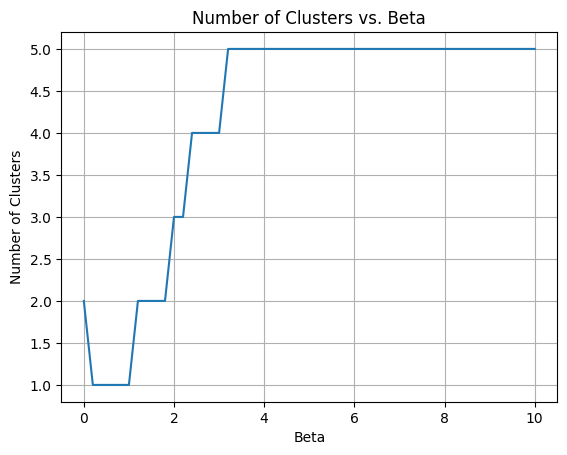

In [34]:
betas = np.linspace(0, 10, 51)
# Initialize an empty list to store the number of clusters
num_clusters_list = []
largest_cluster_sizes = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB_on_alternatives(p_xy_NLM, max_iter=5000, beta=beta, threshold=1e-4)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

        # Calculate the size of the largest cluster
    largest_size = largest_cluster_size(q_t_given_x)
    # Append the size of the largest cluster to the list
    largest_cluster_sizes.append(largest_size)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

In [35]:
q_t_given_x, q_t, q_y_given_t = geom_DIB_on_alternatives(p_xy_NLM, beta=2, max_iter=50000, threshold=1e-5)

Iteration: 1 out of 50000
Objective function value: 1.6025382393790941
H(T) =  1.60914443214705
I(T;Y) =  0.003303096383977966
Iteration: 2 out of 50000
Objective function value: 0.47587560964664477
H(T) =  1.4630759266764477
I(T;Y) =  0.49360015851490147
Iteration: 3 out of 50000
Objective function value: 0.16950524923034638
H(T) =  1.284215485512562
I(T;Y) =  0.5573551181411078
Iteration: 4 out of 50000
Objective function value: 0.09843392626907432
H(T) =  1.2142369538780051
I(T;Y) =  0.5579015138044654
Iteration: 5 out of 50000
Objective function value: 0.06690400648268646
H(T) =  1.1398059015324602
I(T;Y) =  0.5364509475248869
Iteration: 6 out of 50000
Objective function value: 0.06413346992682212
H(T) =  1.132441661019967
I(T;Y) =  0.5341540955465724
Iteration: 7 out of 50000
Objective function value: 0.06262908397761224
H(T) =  1.1287874771741389
I(T;Y) =  0.5330791965982633
Iteration: 8 out of 50000
Objective function value: 0.06135879992300142
H(T) =  1.126190219533607
I(T;Y) =

In [36]:
import re

# Define a function to extract the number from the column name
def extract_number(column_name):
    match = re.search(r'\d+', column_name)  # Search for one or more digits in the column name
    if match:
        return int(match.group())  # Return the first occurrence of digits as an integer
    else:
        return None  # Return None if no digits are found

In [37]:
# Calculate the number of clusters
column_sum = np.sum(q_t_given_x, axis=0)
num_clusters = np.count_nonzero(column_sum)
print('Number of clusters :', num_clusters)

# Count the number of observations in each cluster
simulated_data_lognormal_df['cluster'] = np.argmax(q_t_given_x, axis=1)
print('\n', simulated_data_lognormal_df['cluster'].value_counts())

simulated_data_lognormal_df['max_proba_NLM'] = simulated_data_lognormal_df[['P_1_NLM', 'P_2_NLM', 'P_3_NLM', 'P_4_NLM', 'P_5_NLM']].idxmax(axis=1).apply(extract_number)
cluster_counts2 = simulated_data_lognormal_df.groupby(['cluster', 'max_proba_NLM']).size().unstack(fill_value=0)
print('\n', cluster_counts2)

cluster_counts3 = simulated_data_lognormal_df.groupby(['cluster', 'simulated_choice_NLM']).size().unstack(fill_value=0)
print('\n', cluster_counts3)

Number of clusters : 3

 cluster
0    438
3    390
4    172
Name: count, dtype: int64

 max_proba_NLM    1    2    3    4    5
cluster                               
0              114   20  245   29   30
3                1  135    0    4  250
4                0    4    0  168    0

 simulated_choice_NLM  1.0  2.0  3.0  4.0  5.0
cluster                                      
0                     107   41  213   31   46
3                      14  123    4   16  233
4                      11   12    1  142    6
